In [1]:
from __future__ import print_function
from pathlib import Path
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize
import warnings

%matplotlib inline

In [2]:
cd ../libs

/Users/zhonglingjiang/Desktop/Fall 2019/Big Data Analytics/music_emotion_recognition/libs


In [3]:
from rp_extract.rp_extract import rp_extract
from rp_extract.audiofile_read import *
from rp_extract.rp_plot import *

In [4]:
cd ../notebooks

/Users/zhonglingjiang/Desktop/Fall 2019/Big Data Analytics/music_emotion_recognition/notebooks


In [5]:
audio_path = Path.cwd().parent / '1000songs' / 'clips_45seconds'

## Now aggregate everything
## Part I: Feature Extraction

In [6]:
def append_val(d, k, v):
    if k not in d:
        d[k] = [v]
    else:
        d[k].append(v)
    return d

def salient_pitch(y, sr):
    salient_pitch_index = [i+1 for i in range(1000)]
    salient_pitch_columns = ['salient_pitch_mean', 'salient_pitch_variance']
    salient_pitch_1000_songs = np.zeros(shape = (1000,2))
    
    per_sample_t = 1.0 / sr
    pitch_frame_length, pitch_hop_length = int(50 / 1000 / per_sample_t), int(25 / 1000 / per_sample_t)
    # we hope to introduce an acf - filtered salient pitch
    salient_pitch = []
    num_total_frames = (len(y) - pitch_frame_length) // pitch_hop_length + 1
    for i in range(num_total_frames):
        acf = librosa.core.autocorrelate(y[i*pitch_hop_length : (i*pitch_hop_length+pitch_frame_length)])
        # introduce a filtered acf method
        for j in range(1, len(acf) - 1):
            if acf[j] > acf[j-1] and acf[j] > acf[j+1]:
                if j >= 20 and acf[j] == np.max(acf[j-20:j+20]): # reducing the adjacent HF fluctuation
                    salient_pitch.append(sr / j)
                    break
    return np.array(salient_pitch, dtype = float)

def chroma_centroid(y, sr):
    per_sample_t = 1.0 / sr
    chromagram_frame_length, chromagram_hop_length = int(100 / 1000 / per_sample_t), int(12.5 / 1000 / per_sample_t)
    chromagram_center = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=chromagram_frame_length, \
                                                      hop_length=chromagram_hop_length)[0]
    
    return chromagram_center[1:]
    
def key_clarity(y, sr):
    pass

def temporal_centroid(envelope):
    """computes the temporal centroid of an onset envelope"""
    D = np.abs(librosa.stft(envelope))
    times = librosa.times_like(D)

    onset_strength = librosa.onset.onset_strength(y=envelope, sr=sr)
    
    try:
        temporal_centroid = sum(onset_strength * times) / sum(onset_strength)
    except RuntimeWarning:
        temporal_centroid = np.nan
    
    return temporal_centroid

def log_attack_time(envelope, sr, thresh_percent):
    D = np.abs(librosa.stft(envelope))
    times = librosa.times_like(D)
    onset_strength = librosa.onset.onset_strength(y=envelope, sr=sr)
    
    stop_attack_index = np.argmax(onset_strength)
    stop_attack_value = envelope[stop_attack_index]
    thresh = stop_attack_value * thresh_percent / 100
    
    try:
        start_attack_index = [x > thresh for x in onset_strength].index(True)
    except ValueError:
        return np.nan
    
    if start_attack_index == stop_attack_index:
        start_attack_index -= 1

    log_attack_time =  np.log10(times[stop_attack_index] - times[start_attack_index])
    
    return log_attack_time

def extract_features(signal, sr):
    """Given and a signal and its sampling rate, compute all the features"""
    
    # Harmonic Features 
    # FIXME
    salient_pitches = salient_pitch(signal, sr)
    salient_features = np.array([np.mean(salient_pitches), np.std(salient_pitches)])
    
    chroma_centroids = chroma_centroid(signal, sr)
    chroma_features = np.array([np.mean(chroma_centroids), np.std(chroma_centroids)])
    
    # Temporal Features
    onset_samples = np.unique(librosa.onset.onset_detect(signal, sr=sr, backtrack=True, units='samples'))
    all_envelopes = np.split(signal, onset_samples)
    
    zero_crossings = np.array([sum(librosa.zero_crossings(x, pad=False)) for x in all_envelopes])
    zero_features = np.array([np.mean(zero_crossings), np.std(zero_crossings)])
    
    temporal_centroids = np.array([temporal_centroid(x) for x in all_envelopes])
    temporal_centroids = temporal_centroids[~np.isnan(temporal_centroids)]
    temporal_cen_features = np.array([np.mean(temporal_centroids), np.std(temporal_centroids)])
    
    log_attacks = np.array([log_attack_time(x, sr, 50) for x in all_envelopes])
    log_attacks = log_attacks[~np.isnan(log_attacks)]
    log_attack_features = np.array([np.mean(log_attacks), np.std(log_attacks)])
    
    # Rhythmic Feautres (without dimension reduction for now)
    rhythm = rp_extract(signal, sr, extract_rh=True, transform_db=True, transform_phon=True, transform_sone=True,          
        fluctuation_strength_weighting=True, 
        skip_leadin_fadeout=1,             
        step_width=1)
    rhythm_hist = rhythm['rh']
    rhythm_mean = np.array([np.mean(rhythm_hist)])
    
    # FIXME
    all_features = np.concatenate([salient_features, chroma_features, zero_features, temporal_cen_features, \
                                   log_attack_features, rhythm_hist, rhythm_mean])
    
    return all_features

### [Important]: Filter out songs that are not in KDE annotations

In [7]:
warnings.filterwarnings('ignore')
audio_path = Path.cwd().parent / '1000songs' / 'clips_45seconds'
all_mp3_paths = list(audio_path.glob('**/*.mp3'))
song_ids = []
audio_train = [] 
## FIXME 
for path in tqdm(all_mp3_paths):
    if len(audio_train) < 10: #we'll start off with only 10 training pieces to save time
        signal, sr = librosa.load(str(path))
        try:
            song_features = extract_features(signal, sr)
            audio_train.append(song_features)
            song_ids.append(int((str(path).split('/')[-1].split('.')[0])))

        except ValueError as e:
            print(path)
            continue
    else:
        break

audio_train = np.array(audio_train).T

  1%|          | 10/1000 [00:54<1:27:46,  5.32s/it]

In [8]:
audio_train.shape

(71, 10)

In [40]:
# we need a test song
test_song = '108.mp3'
signal, sr = librosa.load(str(audio_path / test_song))
audio_test = extract_features(signal, sr)

## Part II: Kernel Density Estimation

In [41]:
kernel_density = pd.read_csv('../Time_Average_Gamma_0_1.csv', header=0)
kernel_density.head()

,song_id,"[0,0]","[0,1]","[0,2]","[0,3]","[0,4]","[0,5]","[0,6]","[0,7]","[0,8]",...,"[15,6]","[15,7]","[15,8]","[15,9]","[15,10]","[15,11]","[15,12]","[15,13]","[15,14]","[15,15]"
0,2,0.003781,0.003843,0.003895,0.003934,0.003962,0.003978,0.003981,0.003972,0.003950,...,0.003695,0.003687,0.003667,0.003636,0.003594,0.003541,0.003479,0.003406,0.003325,0.003236
1,3,0.003811,0.003870,0.003917,0.003952,0.003975,0.003986,0.003984,0.003970,0.003944,...,0.003705,0.003692,0.003667,0.003632,0.003585,0.003528,0.003461,0.003385,0.003300,0.003208
2,4,0.003245,0.003330,0.003406,0.003473,0.003530,0.003577,0.003614,0.003639,0.003653,...,0.003959,0.003987,0.004003,0.004006,0.003996,0.003974,0.003940,0.003895,0.003837,0.003769
3,5,0.003561,0.003652,0.003734,0.003806,0.003868,0.003918,0.003956,0.003983,0.003996,...,0.003621,0.003645,0.003657,0.003659,0.003649,0.003627,0.003595,0.003552,0.003498,0.003434
4,7,0.003059,0.003153,0.003239,0.003318,0.003387,0.003448,0.003498,0.003539,0.003568,...,0.004027,0.004073,0.004107,0.004129,0.004137,0.004133,0.004115,0.004085,0.004043,0.003988


In [42]:
# Just take a subsample - 4 songs ['752.mp3', '746.mp3', '791.mp3', '949.mp3' ]
# For code debug purpose
song_ids 

[752, 746, 791, 949, 785, 975, 961, 550, 236, 222]

## Part III: Mapping Factor Learning

In [43]:
# Non-negative sparse representation (SR+) seems require solution >0
# Need to enforce additional condition

lamda = 0.01
def estimate(x, beta):
    """The function estimates linear outcome given an observation and a coeffcient vector."""
    yhat = np.dot(x, beta)
    return yhat

def RSS_L1(beta, X, y, lamda):
    y_hat = np.dot(X, beta)
    return np.sqrt(np.sum((y - y_hat)**2)) + lamda* np.sum(np.abs(beta))

beta0 = np.random.normal(0, 1, audio_train.shape[1])
res = minimize(fun=RSS_L1, x0=beta0, args=(audio_train, audio_test, lamda))
beta_hat = res.x
mapping_factors = beta_hat
print('The estimated β vector is: \n')
print(mapping_factors)

The estimated β vector is: 

[ 0.7045898   0.98302615  0.55975749  1.12775469 -1.17007574 -0.0704679  -0.28823551 -0.47658883 -0.2652435   0.7169799 ]


### Part IV: Emotion Space Mapping

In [44]:
pred_emotion = np.zeros(16 * 16)
for i, s_id in enumerate(song_ids):
    if (kernel_density.loc[kernel_density['song_id'] == s_id, ].shape[0] == 0):
        emotion_val = np.zeros(16 * 16)
    else: 
        emotion_val = kernel_density.loc[kernel_density['song_id'] == s_id, ]. \
                        drop(['song_id'], axis=1).values[0]
    pred_emotion += mapping_factors[i] * emotion_val
pred_emotion

array([0.00824383, 0.0084382 , 0.00861035, 0.00875876, 0.00888209, 0.00897921, 0.00904924, 0.00909154, 0.0091057 , 0.00909161, ..., 0.00886985, 0.00891691, 0.00893646, 0.00892831, 0.00889254,
       0.00882949, 0.00873973, 0.00862411, 0.00848366, 0.00831967])

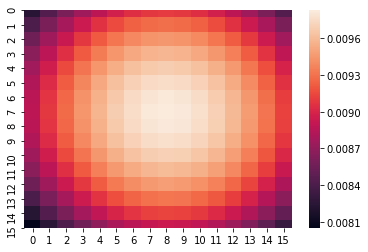

In [46]:
# Our prediction
import seaborn as sns
pred_emotion_reshape = np.reshape(pred_emotion, (16, 16))
sns.heatmap(pred_emotion_reshape)
plt.show()

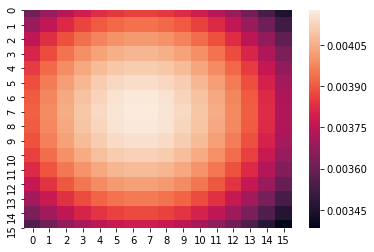

In [47]:
# Actual 
actual_emotion = kernel_density.loc[kernel_density['song_id'] == int(test_song.split('.')[0]), ]. \
                    drop(['song_id'], axis=1).values[0]
actual_emotion_reshape = np.reshape(actual_emotion, (16, 16))
sns.heatmap(actual_emotion_reshape)
plt.show()